### `list_attr_celeba` Dataset
A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).



- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image

You can obtain the dataset from https://www.kaggle.com/jessicali9530/celeba-dataset

In [1]:
import os
# Remove any existing LD_LIBRARY_PATH to avoid conflicts
os.environ.pop("LD_LIBRARY_PATH", None)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.5"

import tensorflow as tf
import numpy as np
import pandas as pd 
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPool2D, Flatten

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Device Name:", tf.test.gpu_device_name())
print("List of GPUs:", tf.config.list_physical_devices('GPU'))

2025-02-22 03:22:40.751765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 03:22:40.760815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740223360.772202   26632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740223360.775663   26632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 03:22:40.787048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1
TensorFlow version: 2.18.0
Built with CUDA: True
GPU Device Name: /device:GPU:0
List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-02-22 03:22:42.697593: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1740223362.699394   26632 gpu_device.cc:2022] Created device /device:GPU:0 with 11939 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [2]:
BASIC_PATH = "/home/oem/Downloads/archive"
IMG_PATH = os.path.join(BASIC_PATH,'img_align_celeba/img_align_celeba')
FEATURE_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')

In [3]:
n_images = len(os.listdir(IMG_PATH))
print("Total Images in the Dataset: ", n_images)

Total Images in the Dataset:  202599


In [4]:
# Read the attributes csv files in a dataframe format.
df = pd.read_csv(FEATURE_PATH, usecols=['image_id','Male'])
df = df.sample(n=2500, random_state = 42).reset_index(drop=True)

# Reset the columns values to categorical./
df.loc[df['Male'] == -1,'Male'] = "Female"
df.loc[df['Male'] == 1,'Male'] = "Male"

# Change column names.
df.columns = ["image_id", "Gender"]

df.head(10)

/tmp/ipykernel_26632/1068161277.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Female' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['Male'] == -1,'Male'] = "Female"


,image_id,Gender
0,093242.jpg,Male
1,121414.jpg,Female
2,010625.jpg,Male
3,082524.jpg,Female
4,073193.jpg,Female
5,176200.jpg,Female
6,041602.jpg,Female
7,065466.jpg,Male
8,019028.jpg,Male
9,164498.jpg,Female


#### See sample image

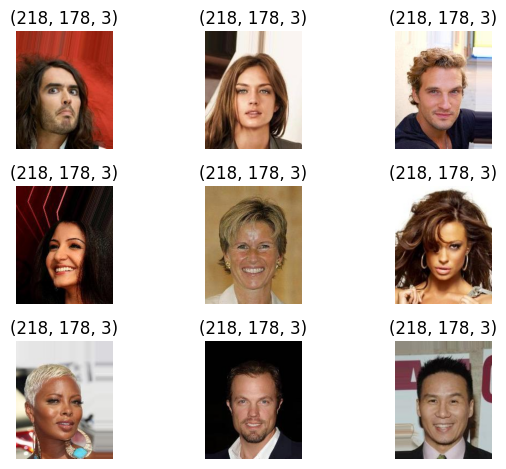

In [5]:
# Display Multiple Sample Images.
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    
    # Read an Image.
    img = cv2.imread(IMG_PATH + '/' + df["image_id"][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display Image.
    plt.imshow(img)
    plt.title(img.shape)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [6]:
# Get the category distribution.
category_count = df["Gender"].value_counts()
print(category_count)

higher_category = list(category_count.index)[0]

Gender
Female    1442
Male      1058
Name: count, dtype: int64


In [7]:
# Get the indices of the higher category indices images.
np.random.seed(42)
indices = df[df["Gender"] == higher_category].index
sample_size = category_count[0] - category_count[1]

# Drop the extra rows of female images to fix class imbalance problem.
drop_sample = np.random.choice(indices, sample_size, replace = False)
df = df.drop(drop_sample, axis = "index")

/tmp/ipykernel_26632/4201299891.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_size = category_count[0] - category_count[1]


<Axes: xlabel='Gender'>

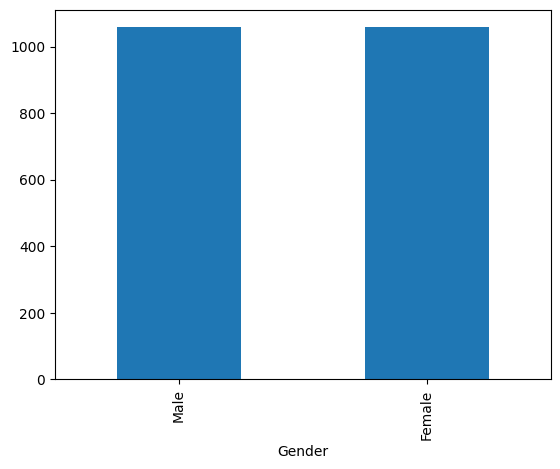

In [8]:
df["Gender"].value_counts().plot.bar()

### 4. Build Model

- First, copy VGG16 without the dense layers, use the weights from `imagenet`. Set the input shape to `(178,218,3)`.
- Freeze the layers except the last two layers and print to see if the layers are trainable or not.
- Build your sequential model (you are free to use a functioanl API as a further exercise). Include all the frozen VGG layers to your model. Add a Dense layer with 128 inouts and `relu` activation. Add a batch nomalizer, then a dense layer as the output layer. 
- Create an early stopping criteria monitorin the loss value for the validation set. Stop the search if the loss value deosnt change for two consecutive times.
- Compile the model.
- Save the best model automatically based on the performance of the validation set.

In [9]:
IMAGE_SIZE = (218, 178)
BATCH_SIZE = 20

In [10]:
base_vgg_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape= IMAGE_SIZE + (3,))

I0000 00:00:1740223363.234347   26632 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11939 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [11]:
base_vgg_model.trainable = False
base_vgg_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 218, 178, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 218, 178, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 218, 178, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 109, 89, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 109, 89, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 109, 89, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 54, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 54, 44, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 54, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 54, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 54, 44, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 27, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 27, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 27, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 27, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 27, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 13, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 13, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 13, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 13, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 13, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [12]:
vgg_model = Sequential([
    base_vgg_model,  # All the frozen VGG layers
    Flatten(),
    Dense(128, activation='relu'),  # Dense layer with 128 inputs and relu activation
    Dropout(0.5),
    BatchNormalization(),           # BatchNormalization comes right after the Dense layer
    Dense(2, activation='softmax')   # Final output layer (adjust activation if needed)
])

In [13]:
vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 6, 5, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,966,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,991,362 (83.89 MB)

 Trainable params: 1,966,722 (7.50 MB)

 Non-trainable params: 20,024,640 (76.39 MB)

In [14]:
vgg_model.compile(optimizer='adam', 
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training if the validation loss doesn't improve for 2 consecutive epochs.
earlystop = EarlyStopping(monitor='val_loss', 
                          patience=4, 
                          verbose=1, 
                          restore_best_weights=True)

# Reduce the learning rate if validation loss doesn't improve for 2 consecutive epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-6)

callbacks = [earlystop, learning_rate_reduction]


## 5. Data Preparation

- Create a validation set with 20% of the data. Check the number of data points per class from both the train and validation sets.
- Set your batch size to 20.
- Create the data generator and set the `preprocessing_function` to `preprocess_input` of VGG16.
- Create train and validation data generators (batches will be picked up from the dataframe). Set target size to (178,218) (you can try something else, but you need to do the corresponding change in the model).
- Set your validation  and epoch step size (`validation_steps` and `steps_per_epoch`)

In [16]:
train_df, test_df = train_test_split(df, test_size=0.3)
train_df['Gender'] = train_df['Gender'].astype(str)
test_df, validation_df = train_test_split(test_df, test_size=0.667)

In [17]:
print("Total Train Sample Images : ", len(train_df))
print("Total Test Sample Images : ", len(test_df))
print("Total Validation Sample Images : ", len(validation_df))

Total Train Sample Images :  1481
Total Test Sample Images :  211
Total Validation Sample Images :  424


In [18]:
# Generate Train Images Data Generator.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    IMG_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 1481 validated image filenames belonging to 2 classes.


In [19]:
# Generate Validation Images Data Generator.
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    IMG_PATH + "/", 
    x_col='image_id',
    y_col='Gender',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 424 validated image filenames belonging to 2 classes.


In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    IMG_PATH + "/",  
    x_col='image_id',
    y_col='Gender',
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 211 validated image filenames belonging to 2 classes.


## 6. Train the Model

- Fit the model
- save the model

In [21]:
history = vgg_model.fit(train_generator, 
                        validation_data = validation_generator, 
                        validation_steps=len(validation_df)//BATCH_SIZE, 
                        steps_per_epoch=len(train_df)//BATCH_SIZE,
                        epochs=20, 
                        verbose = 1, 
                        callbacks=callbacks)

Epoch 1/20


/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740223365.097845   26716 service.cc:148] XLA service 0x775d6c411730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740223365.097862   26716 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-02-22 03:22:45.121786: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740223365.303364   26716 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/74 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5972 - loss: 0.7658

I0000 00:00:1740223369.380161   26716 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.7340 - loss: 0.5476 - val_accuracy: 0.8500 - val_loss: 0.3625 - learning_rate: 0.0010
Epoch 2/20
 1/74 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9000 - loss: 0.3093

/home/oem/Documents/github/magnimind_projects/magpenv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9000 - loss: 0.3093 - val_accuracy: 0.8524 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.8300 - loss: 0.4011 - val_accuracy: 0.7833 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 4/20
 1/74 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8000 - loss: 0.4129
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8000 - loss: 0.4129 - val_accuracy: 0.7905 - val_loss: 0.4207 - learning_rate: 0.0010
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.8163 - loss: 0.3912 - val_accuracy: 0.8667 - val_loss: 0.3302 - learning_rate: 5.0000e-04
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7500 - loss: 0.3753 - val_accuracy: 0.8714 - val_loss: 0.3298 - learning_rate: 5.0000e-04
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8634 - loss: 0.3442 - val_accurac

In [22]:
vgg_model.save("./models/gender_model.h5")

## 7. Load and Use the Model

In [23]:
vgg_model = tf.keras.models.load_model("./models/gender_model.h5")

In [24]:
vgg_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 6, 5, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,966,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,991,364 (83.89 MB)

 Trainable params: 1,966,722 (7.50 MB)

 Non-trainable params: 20,024,640 (76.39 MB)

 Optimizer params: 2 (12.00 B)

Predictions & Testing Model

In [25]:
x_dummy, y_dummy = next(test_generator)
_ = vgg_model.predict(x_dummy)

test_generator.reset()
vgg_model.evaluate(test_generator, steps=len(test_generator))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.9018 - loss: 0.2460


[0.2215491235256195, 0.9146919250488281]

In [26]:
predict = vgg_model.predict(test_generator, steps=int(np.ceil(len(test_df) / BATCH_SIZE)))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step 


In [27]:
prediction = predict.argmax(axis=-1)
test_df['Prediction'] = ["Male" if ele == 1 else "Female" for ele in prediction]


test_df

,image_id,Gender,Prediction
1440,043815.jpg,Male,Male
1620,140719.jpg,Female,Female
800,180012.jpg,Male,Male
1270,140315.jpg,Female,Female
1382,130961.jpg,Female,Female
...,...,...,...
33,191989.jpg,Female,Female
823,147495.jpg,Female,Female
780,187640.jpg,Male,Male
612,152534.jpg,Male,Female


In [28]:
labels = ['Male','Female']

cm = confusion_matrix(test_df['Gender'], test_df["Prediction"], labels= labels)
cm

array([[ 90,   8],
       [ 10, 103]])

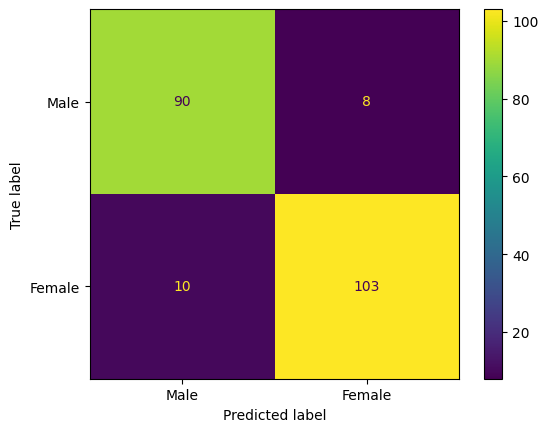

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.show()

In [30]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions
predictions = vgg_model.predict(test_generator, steps=int(np.ceil(len(test_df) / BATCH_SIZE)))
# For a two-class problem with softmax, convert probabilities to class indices:
y_pred = np.argmax(predictions, axis=1)

# Extract true labels from the generator.
# If you created the generator with class_mode='categorical',
# the generator should have a `.classes` attribute.
y_true = test_generator.classes

# Print the classification report.
print(classification_report(y_true, y_pred))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       113
           1       0.90      0.92      0.91        98

    accuracy                           0.91       211
   macro avg       0.91      0.91      0.91       211
weighted avg       0.91      0.91      0.91       211

